<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#class_weight" data-toc-modified-id="class_weight-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>class_weight</a></span></li><li><span><a href="#Увеличение-выборки" data-toc-modified-id="Увеличение-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Увеличение выборки</a></span></li><li><span><a href="#Уменьшение-выборки" data-toc-modified-id="Уменьшение-выборки-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Уменьшение выборки</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Прогнозирование оттока клиента Банка

### Описание исследования
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)
_____

### Цель исследования
На основе данных из банка определить клиента, который может уйти.
_____
### Исходные данные
   - `RowNumber` — индекс строки в данных
   - `CustomerId` — уникальный идентификатор клиента
   - `Surname` — фамилия
   - `CreditScore` — кредитный рейтинг
   - `Geography` — страна проживания
   - `Gender` — пол
   - `Age` — возраст
   - `Tenure` — сколько лет человек является клиентом банка
   - `Balance` — баланс на счёте
   - `NumOfProducts` — количество продуктов банка, используемых клиентом
   - `HasCrCard` — наличие кредитной карты
   - `IsActiveMember` — активность клиента
   - `EstimatedSalary` — предполагаемая зарплата
   - `Exited` — факт ухода клиента
_____


## Подготовка данных

In [1]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    precision_recall_curve,
    roc_curve,
    RocCurveDisplay,
    f1_score, 
    roc_auc_score,
    plot_confusion_matrix
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

# настройки
warnings.filterwarnings("ignore")

In [2]:
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
#посмотрим информацию  о типе столбцов
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
#выведем количество пропусков в каждом столбце
data.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [5]:
#Выведем уникальные значение в столбце Tenure, чтобы понять разброс значений и чем их лучше заполнить
data['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [6]:
data['Tenure'].value_counts(normalize=True, dropna=False)

Tenure
1.0     0.0952
2.0     0.0950
8.0     0.0933
3.0     0.0928
5.0     0.0927
7.0     0.0925
NaN     0.0909
4.0     0.0885
9.0     0.0882
6.0     0.0881
10.0    0.0446
0.0     0.0382
Name: proportion, dtype: float64

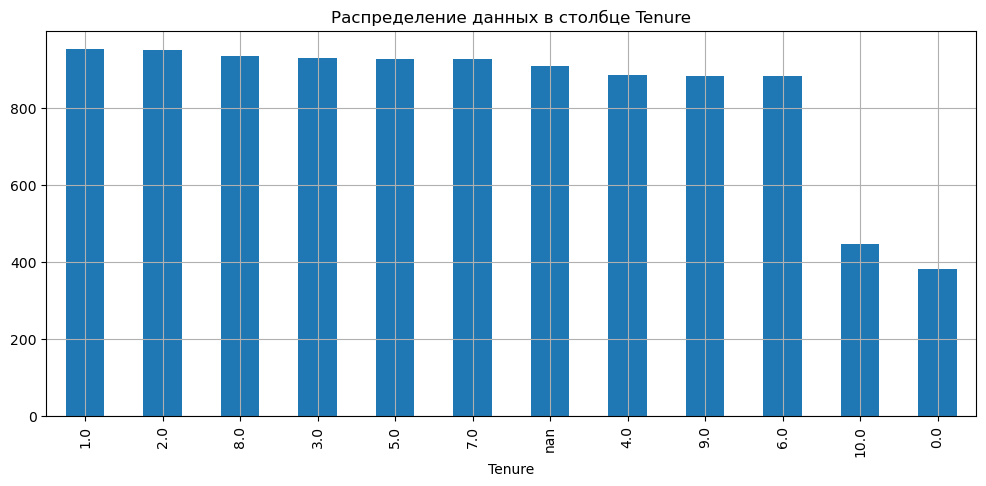

In [7]:
data['Tenure'].value_counts(dropna=False).plot(kind='bar', grid=True, figsize=(12, 5))
plt.title('Распределение данных в столбце Tenure')
plt.show()

столбец Tenure отображает сколько лет человек является клиентом банка, и принимает значения от 0 до 10. Есть несколько вариантов заполнить пропуски:
- нулями, предположив что это новые клиенты;
- медианой;
- заполнить пропуски случайными значениями. 

Наша задача − минимизировать ошибку, то есть, разницу между ожидаемым значением в пропуске и значением, которым мы этот пропуск заменим. Вероятность будет выше в месте наибольшей плотности распределения значений. И хотя мы видим, что на гистограмме найти такую область (пик) сложно, заполненим медианным значением. 

In [8]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

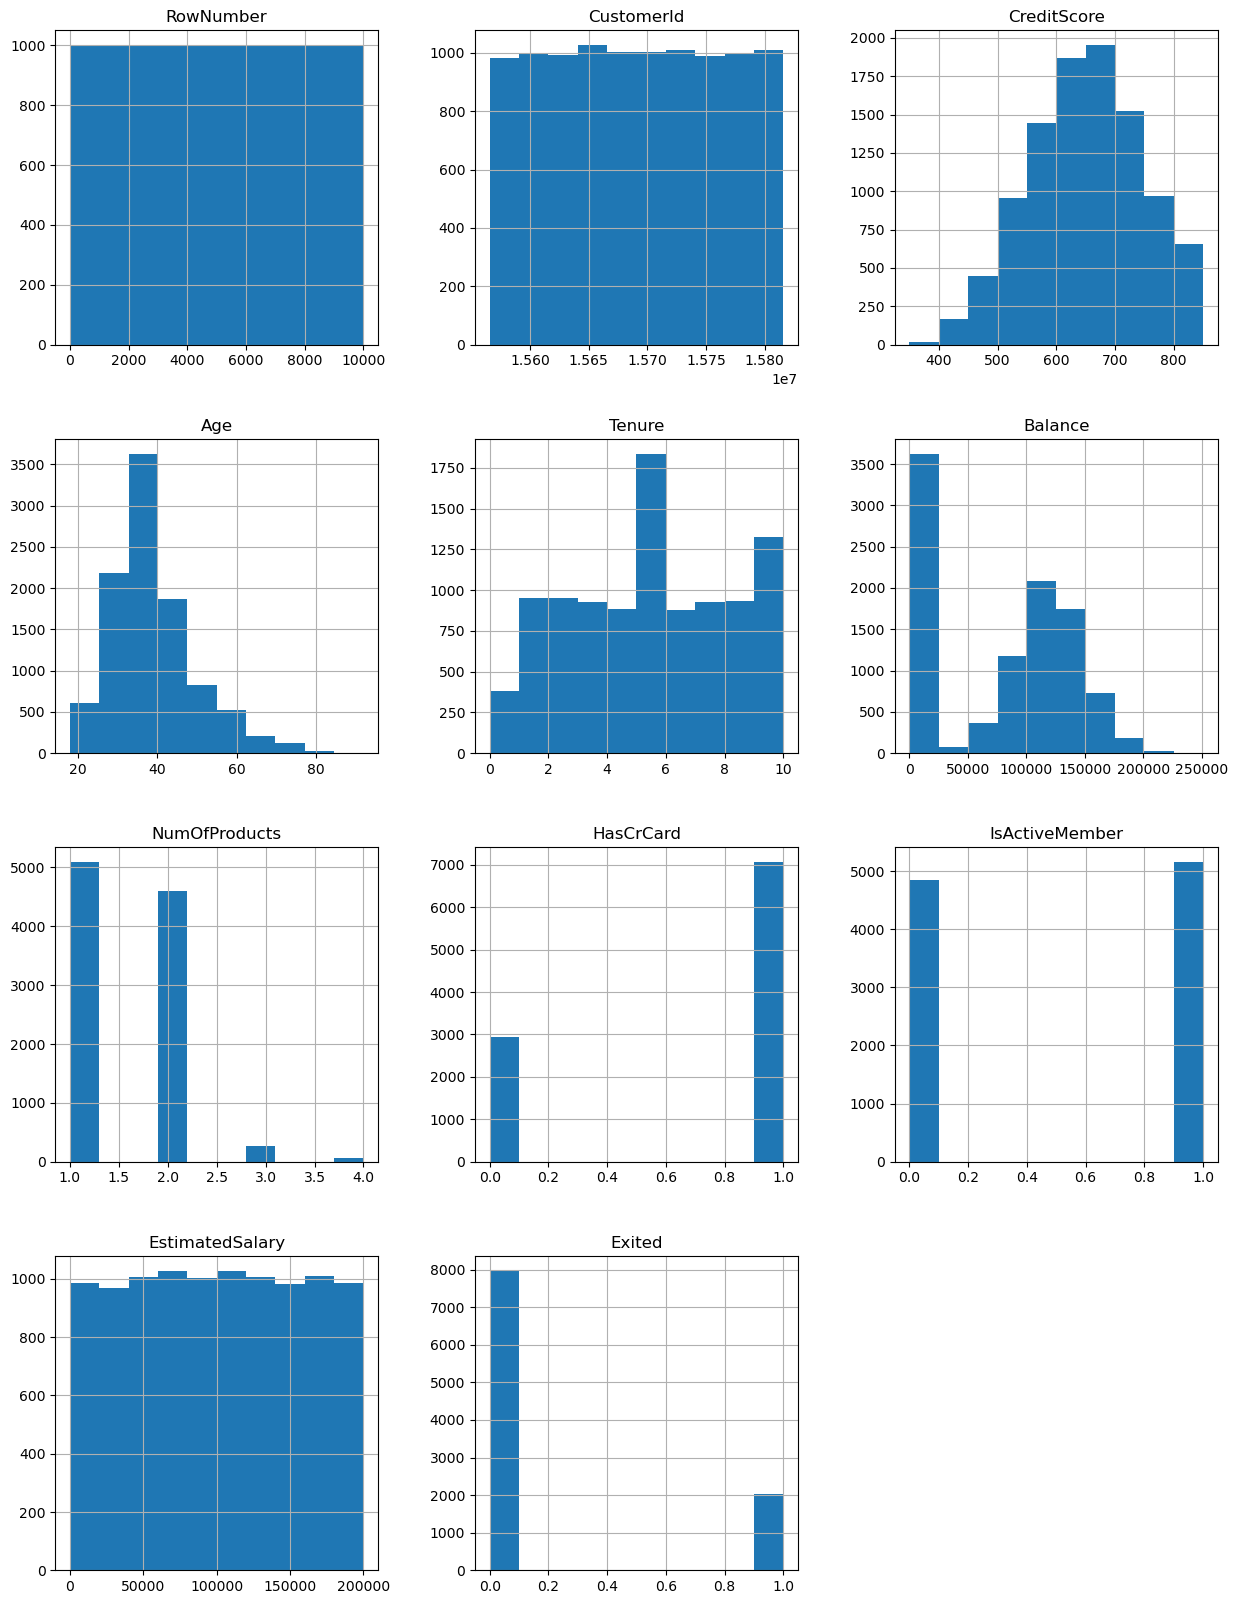

In [9]:
#Отобразим с помощью графиков как распределены значения в столбцах
data.hist(figsize=(15, 20))
plt.show()

In [10]:
#с помощью фунции describe отобразим представление о распределении значений
data.describe().round(2)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,5000.50,15690940.57,650.53,38.92,5.00,76485.89,1.53,0.71,0.52,100090.24,0.2
std,2886.90,71936.19,96.65,10.49,2.76,62397.41,0.58,0.46,0.50,57510.49,0.4
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,2500.75,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.0
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,0.0
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0


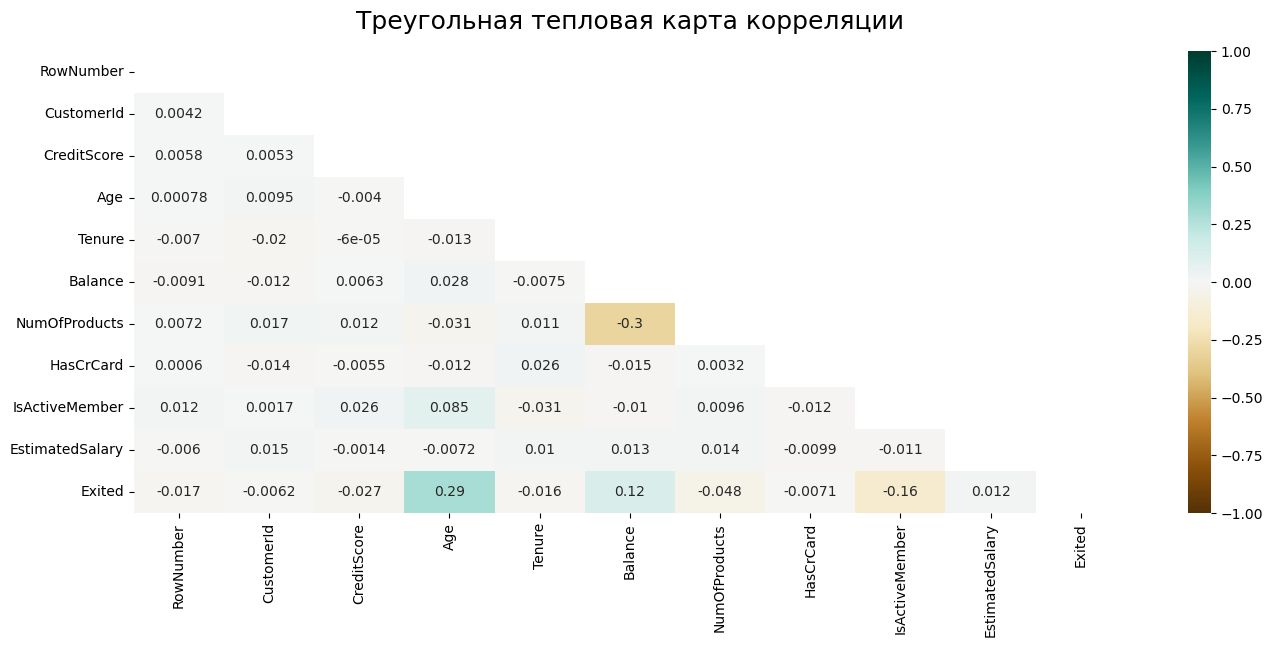

In [11]:
#Отобразим корреляцию столбцов 

plt.figure(figsize=(16, 6)) 
mask = np.triu(np.ones_like(data.corr(numeric_only=True), dtype=bool)) 
heatmap = sns.heatmap(data.corr(numeric_only=True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Треугольная тепловая карта корреляции', fontdict={'fontsize':18}, pad=16);

In [12]:
print("Количесвто явных дубликатов:", data.duplicated().sum())

Количесвто явных дубликатов: 0


In [13]:
#столбец Surname явно лишнее. Удалим его.
data.drop(columns='Surname', inplace=True)


In [14]:
#столбцы RowNumber и CustomerId тоже неинфомативны. удаляем
data.drop(columns='RowNumber', inplace=True)
data.drop(columns='CustomerId', inplace=True)

## Исследование задачи

In [15]:
#разделим выборки на тренировочную, ввлидационную и тестовую в соотношении 6:2:2
features = data.drop(['Exited'], axis=1)
target = data['Exited']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345
)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345
)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 10)
(2000, 10)
(2000, 10)


In [16]:
features_train_ridge = features_train.copy()
features_valid_ridge = features_valid.copy()
features_test_ridge = features_test.copy()

In [17]:
#категориальные признаки
ohe_features_ridge = ['Gender', 'Geography']
#численные признаки
num_features = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
    'HasCrCard', 'IsActiveMember', 'EstimatedSalary'
]

In [18]:
# используем OHE кодирование категориальных признаков и StandardScaler для численных признаков. 
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features_train_ridge[ohe_features_ridge])

features_train_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_ridge[ohe_features_ridge])

features_train_ridge = features_train_ridge.drop(ohe_features_ridge, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train_ridge[num_features] = scaler.fit_transform(features_train_ridge[num_features])

# смотрим на результат
features_train_ridge.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
7479,-0.886751,-0.373192,1.082277,1.232271,-0.891560,0.642466,-1.055187,-0.187705,1.0,0.0,1.0
3411,0.608663,-0.183385,1.082277,0.600563,-0.891560,-1.556504,-1.055187,-0.333945,0.0,0.0,0.0
6027,2.052152,0.480939,-0.737696,1.027098,0.830152,-1.556504,0.947699,1.503095,1.0,1.0,0.0
1247,-1.457915,-1.417129,0.354288,-1.233163,0.830152,0.642466,-1.055187,-1.071061,1.0,0.0,0.0
3716,0.130961,-1.132419,-1.101690,1.140475,-0.891560,-1.556504,-1.055187,1.524268,0.0,1.0,0.0


In [19]:
features_valid_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid_ridge[ohe_features_ridge])

features_valid_ridge = features_valid_ridge.drop(ohe_features_ridge, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем валидационную
features_valid_ridge[num_features] = scaler.transform(
    features_valid_ridge[num_features]
)

# смотрим на результат
features_valid_ridge.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
7041,-2.226392,-0.088482,-1.101690,-1.233163,0.830152,0.642466,-1.055187,0.647083,1.0,0.0,0.0
5709,-0.087120,0.006422,1.446272,-1.233163,-0.891560,0.642466,-1.055187,-1.658410,0.0,0.0,0.0
7117,-0.917905,-0.752805,-0.009707,0.722307,-0.891560,0.642466,0.947699,-1.369334,1.0,0.0,1.0
7775,-0.253277,0.101325,1.810266,-1.233163,0.830152,0.642466,-1.055187,0.075086,1.0,0.0,1.0
8735,0.785204,-0.847708,1.810266,0.615625,-0.891560,-1.556504,0.947699,-1.070919,1.0,0.0,0.0


In [20]:
features_test_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ridge[ohe_features_ridge])

features_test_ridge = features_test_ridge.drop(ohe_features_ridge, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
features_test_ridge[num_features] = scaler.transform(
    features_test_ridge[num_features]
)

# смотрим на результат
features_test_ridge.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
8532,-0.699824,-0.373192,-1.101690,-1.233163,0.830152,0.642466,-1.055187,-0.015173,0.0,0.0,0.0
5799,-0.284431,0.575842,-0.737696,-1.233163,-0.891560,0.642466,0.947699,1.471724,0.0,0.0,0.0
5511,0.151731,-0.657902,-1.829679,0.438711,-0.891560,0.642466,-1.055187,-1.367107,1.0,1.0,0.0
7365,-0.876366,-0.278288,1.810266,1.239884,-0.891560,0.642466,0.947699,-0.786517,0.0,0.0,1.0
7367,-0.481743,0.291132,1.810266,-1.233163,0.830152,0.642466,-1.055187,1.358533,1.0,0.0,1.0


In [21]:
#проверим размеры
print(features_train_ridge.shape)
print(features_valid_ridge.shape)
print(features_test_ridge.shape)

(6000, 11)
(2000, 11)
(2000, 11)


In [22]:
# посмотрим соотношение данных в target_train
target_train.value_counts(normalize=True)

Exited
0    0.800667
1    0.199333
Name: proportion, dtype: float64

> В нашей задаче наблюдается сильный дисбаланс классов. 

In [23]:
#Модель дерева решений без учёта дисбаланса

best_f1_dtc = 0
best_depth_dtc = 0
best_auc_roc = 0
for depth in range(1, 15):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc.fit(features_train_ridge, target_train)
    predicted_valid_dtc = model_dtc.predict(features_valid_ridge)
    f1_dtc = f1_score(target_valid, predicted_valid_dtc)
    auc_roc_dtc = roc_auc_score(target_valid, model_dtc.predict_proba(features_valid_ridge)[:, 1])
    print("F1 = {:.3f}, AUC-ROC = {:.3f}".format(f1_dtc, auc_roc_dtc), 'на шаге', depth)
    if f1_dtc > best_f1_dtc:
        best_f1_dtc = f1_dtc
        best_depth_dtc = depth
        best_auc_roc = auc_roc_dtc
        
print()
print('F1 для дерева решений =', best_f1_dtc)
print('Максимальная глубина =', best_depth_dtc)
print('AUC-ROC =', best_auc_roc)

F1 = 0.000, AUC-ROC = 0.681 на шаге 1
F1 = 0.499, AUC-ROC = 0.728 на шаге 2
F1 = 0.380, AUC-ROC = 0.792 на шаге 3
F1 = 0.483, AUC-ROC = 0.812 на шаге 4
F1 = 0.502, AUC-ROC = 0.831 на шаге 5
F1 = 0.534, AUC-ROC = 0.839 на шаге 6
F1 = 0.507, AUC-ROC = 0.826 на шаге 7
F1 = 0.488, AUC-ROC = 0.802 на шаге 8
F1 = 0.531, AUC-ROC = 0.778 на шаге 9
F1 = 0.498, AUC-ROC = 0.753 на шаге 10
F1 = 0.491, AUC-ROC = 0.709 на шаге 11
F1 = 0.489, AUC-ROC = 0.700 на шаге 12
F1 = 0.488, AUC-ROC = 0.686 на шаге 13
F1 = 0.491, AUC-ROC = 0.682 на шаге 14

F1 для дерева решений = 0.5337423312883436
Максимальная глубина = 6
AUC-ROC = 0.8394526219847661


In [24]:
#Модель логистической регрессии без учёта дисбаланса

model_lg = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model_lg.fit(features_train_ridge, target_train)
predicted_valid_lg = model_lg.predict(features_valid_ridge)
print('F1 для логистической регрессии =', f1_score(target_valid, predicted_valid_lg))
print('AUC-ROC для логистической регрессии =', roc_auc_score(target_valid, model_lg.predict_proba(features_valid_ridge)[:, 1]))

F1 для логистической регрессии = 0.27478260869565213
AUC-ROC для логистической регрессии = 0.7386919833121213


In [25]:
#Модель случайного леса без учёта дисбаланса

best_f1_rfc = 0
best_depth_rfc = 0
best_est_rfc = 0
best_roc_auc_score_rfc = 0
for depth in range(1, 10):
    for est in range(1, 100):
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rfc.fit(features_train_ridge, target_train)
        predicted_valid_rfc = model_rfc.predict(features_valid_ridge)
        f1_rfc = f1_score(target_valid, predicted_valid_rfc)
        roc_auc_score_rfc = roc_auc_score(target_valid, model_rfc.predict_proba(features_valid_ridge)[:,1])
        if f1_rfc > best_f1_rfc:
            best_f1_rfc = f1_rfc
            best_depth_rfc = depth
            best_est_rfc = est
            best_roc_auc_score_rfc = roc_auc_score_rfc
            
print('F1 для случайного леса =', best_f1_rfc)
print('Максимальная глубина =', best_depth_rfc)
print('Число деревьев =', best_est_rfc)
print('AUC-ROC =', best_roc_auc_score_rfc)

F1 для случайного леса = 0.5285935085007728
Максимальная глубина = 9
Число деревьев = 56
AUC-ROC = 0.855145854039525


>Провели обучение моделей без учета дисбаланса. Лучшие показатели у модели дерева решений: F1 = 0.53.
Для этой модели построим матрицу ошибок и найдем долю верно найденного оттока клиентов.

In [26]:
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=6)
model_dtc.fit(features_train_ridge, target_train)
predicted_valid_dtc = model_dtc.predict(features_valid_ridge)
f1_dtc = f1_score(target_valid, predicted_valid_dtc)
auc_roc_dtc = roc_auc_score(target_valid, model_dtc.predict_proba(features_valid_ridge)[:, 1])
f1_dtc

0.5337423312883436

In [27]:
#Наглядно представиv результаты вычислений метрик точности и полноты .
#построим матрицу ошибок
cm = confusion_matrix(target_valid, predicted_valid_rfc, labels=model_rfc.classes_)
cm

array([[1527,   50],
       [ 260,  163]], dtype=int64)

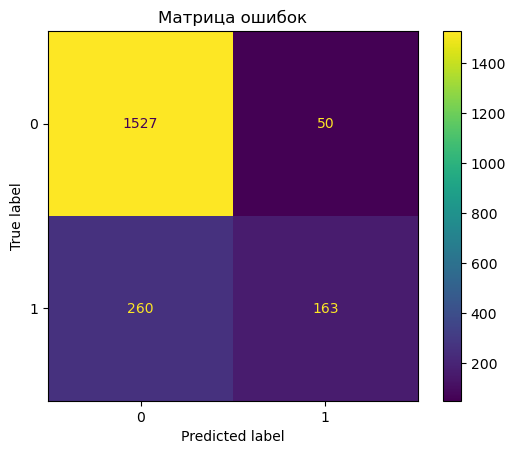

In [29]:
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot()
plt.title('Матрица ошибок')
plt.show()
#у меня не получилось присвоить название графику ... 

In [30]:
#recall - доля верно найденного оттока клиентов.

print('доля верно найденного оттока клиентов:', recall_score(target_valid, predicted_valid_dtc))

доля верно найденного оттока клиентов: 0.41134751773049644


На Матрице ошибок на главной диагонали показано количество правильно классифицированных примеров.
recall - доля верно найденного оттока клиентов составила - 0.41


## Борьба с дисбалансом

Устраним дисбаланс тремя способами, и посмотрим результаты:
- class_weight;
- увеличение выборки;
- уменьшение выборки.

### class_weight

In [31]:
#Модель дерева решений с учётом дисбаланса (метод class_weight)

best_f1_dtc = 0
best_depth_dtc = 0
best_auc_roc = 0
for depth in range(1, 15):
    model_dtc = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth=depth)
    model_dtc.fit(features_train_ridge, target_train)
    predicted_valid_dtc = model_dtc.predict(features_valid_ridge)
    f1_dtc = f1_score(target_valid, predicted_valid_dtc)
    auc_roc_dtc = roc_auc_score(target_valid, model_dtc.predict_proba(features_valid_ridge)[:, 1])
    print("F1 = {:.3f}, AUC-ROC = {:.3f}".format(f1_dtc, auc_roc_dtc), 'на шаге', depth)
    if f1_dtc > best_f1_dtc:
        best_f1_dtc = f1_dtc
        best_depth_dtc = depth
        best_auc_roc = auc_roc_dtc
        
print()
print('F1 для дерева решений с учетом дисбаланса методом class_weight =', best_f1_dtc)
print('Максимальная глубина =', best_depth_dtc)
print('AUC-ROC =', best_auc_roc)

F1 = 0.485, AUC-ROC = 0.681 на шаге 1
F1 = 0.513, AUC-ROC = 0.728 на шаге 2
F1 = 0.513, AUC-ROC = 0.791 на шаге 3
F1 = 0.539, AUC-ROC = 0.819 на шаге 4
F1 = 0.581, AUC-ROC = 0.836 на шаге 5
F1 = 0.564, AUC-ROC = 0.819 на шаге 6
F1 = 0.559, AUC-ROC = 0.800 на шаге 7
F1 = 0.548, AUC-ROC = 0.781 на шаге 8
F1 = 0.549, AUC-ROC = 0.776 на шаге 9
F1 = 0.526, AUC-ROC = 0.754 на шаге 10
F1 = 0.522, AUC-ROC = 0.741 на шаге 11
F1 = 0.524, AUC-ROC = 0.725 на шаге 12
F1 = 0.514, AUC-ROC = 0.707 на шаге 13
F1 = 0.508, AUC-ROC = 0.697 на шаге 14

F1 для дерева решений с учетом дисбаланса методом class_weight = 0.5809128630705395
Максимальная глубина = 5
AUC-ROC = 0.8355347481752318


In [32]:
#Модель логистической регрессии с учётом дисбаланса

model_lg = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear', max_iter=1000)
model_lg.fit(features_train_ridge, target_train)
predicted_valid_lg = model_lg.predict(features_valid_ridge)
print('F1 для логистической регрессии с учетом дисбаланса методом class_weight =', f1_score(target_valid, predicted_valid_lg))
print('AUC-ROC для логистической регрессии =', roc_auc_score(target_valid, model_lg.predict_proba(features_valid_ridge)[:, 1]))

F1 для логистической регрессии с учетом дисбаланса методом class_weight = 0.4775086505190312
AUC-ROC для логистической регрессии = 0.7417201467310076


In [33]:
#Модель случайного леса с учётом дисбаланса

best_f1_rfc = 0
best_depth_rfc = 0
best_est_rfc = 0
best_roc_auc_score_rfc = 0
for depth in range(1, 10):
    for est in range(1, 100):
        model_rfc = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=est, max_depth=depth)
        model_rfc.fit(features_train_ridge, target_train)
        predicted_valid_rfc = model_rfc.predict(features_valid_ridge)
        f1_rfc = f1_score(target_valid, predicted_valid_rfc)
        roc_auc_score_rfc = roc_auc_score(target_valid, model_rfc.predict_proba(features_valid_ridge)[:,1])
        if f1_rfc > best_f1_rfc:
            best_f1_rfc = f1_rfc
            best_depth_rfc = depth
            best_est_rfc = est
            best_roc_auc_score_rfc = roc_auc_score_rfc
            
print('F1 для случайного леса с учетом дисбаланса методом class_weight =', best_f1_rfc)
print('Максимальная глубина =', best_depth_rfc)
print('Число деревьев =', best_est_rfc)
print('AUC-ROC =', best_roc_auc_score_rfc)

F1 для случайного леса с учетом дисбаланса методом class_weight = 0.6226012793176973
Максимальная глубина = 8
Число деревьев = 83
AUC-ROC = 0.8564620557631796


### Увеличение выборки

In [34]:
oversample = SMOTE(random_state=12345)

features_upsampled, target_upsampled = oversample.fit_resample(features_train_ridge, target_train)

In [35]:
#Модель дерева решений с учётом дисбаланса

best_f1_dtc = 0
best_depth_dtc = 0
best_auc_roc = 0
for depth in range(1, 15):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc.fit(features_upsampled, target_upsampled)
    predicted_valid_dtc = model_dtc.predict(features_valid_ridge)
    f1_dtc = f1_score(target_valid, predicted_valid_dtc)
    auc_roc_dtc = roc_auc_score(target_valid, model_dtc.predict_proba(features_valid_ridge)[:, 1])
    print("F1 = {:.3f}, AUC-ROC = {:.3f}".format(f1_dtc, auc_roc_dtc), 'на шаге', depth)
    if f1_dtc > best_f1_dtc:
        best_f1_dtc = f1_dtc
        best_depth_dtc = depth
        best_auc_roc = auc_roc_dtc
        
print()
print('F1 для дерева решений с учетом дисбаланса методом увеличения выборки =', best_f1_dtc)
print('Максимальная глубина =', best_depth_dtc)
print('AUC-ROC =', best_auc_roc)

F1 = 0.475, AUC-ROC = 0.679 на шаге 1
F1 = 0.462, AUC-ROC = 0.731 на шаге 2
F1 = 0.515, AUC-ROC = 0.758 на шаге 3
F1 = 0.515, AUC-ROC = 0.780 на шаге 4
F1 = 0.524, AUC-ROC = 0.809 на шаге 5
F1 = 0.563, AUC-ROC = 0.825 на шаге 6
F1 = 0.552, AUC-ROC = 0.816 на шаге 7
F1 = 0.567, AUC-ROC = 0.803 на шаге 8
F1 = 0.536, AUC-ROC = 0.797 на шаге 9
F1 = 0.562, AUC-ROC = 0.795 на шаге 10
F1 = 0.556, AUC-ROC = 0.769 на шаге 11
F1 = 0.549, AUC-ROC = 0.758 на шаге 12
F1 = 0.520, AUC-ROC = 0.740 на шаге 13
F1 = 0.519, AUC-ROC = 0.718 на шаге 14

F1 для дерева решений с учетом дисбаланса методом увеличения выборки = 0.5668103448275863
Максимальная глубина = 8
AUC-ROC = 0.8026139646304516


In [36]:
#Модель случайного леса с учётом дисбаланса

best_f1_rfc = 0
best_depth_rfc = 0
best_est_rfc = 0
best_roc_auc_score_rfc = 0
for depth in range(1, 10):
    for est in range(1, 100):
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rfc.fit(features_upsampled, target_upsampled)
        predicted_valid_rfc = model_rfc.predict(features_valid_ridge)
        f1_rfc = f1_score(target_valid, predicted_valid_rfc)
        roc_auc_score_rfc = roc_auc_score(target_valid, model_rfc.predict_proba(features_valid_ridge)[:,1])
        if f1_rfc > best_f1_rfc:
            best_f1_rfc = f1_rfc
            best_depth_rfc = depth
            best_est_rfc = est
            best_roc_auc_score_rfc = roc_auc_score_rfc
            
print('F1 для случайного леса с учетом дисбаланса методом увеличения выборки =', best_f1_rfc)
print('Максимальная глубина =', best_depth_rfc)
print('Число деревьев =', best_est_rfc)
print('AUC-ROC =', best_roc_auc_score_rfc)

F1 для случайного леса с учетом дисбаланса методом увеличения выборки = 0.6255411255411255
Максимальная глубина = 8
Число деревьев = 27
AUC-ROC = 0.8548377908798314


### Уменьшение выборки

In [37]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train_ridge, target_train, 0.1)

In [38]:
#Модель дерева решений с учётом дисбаланса

best_f1_dtc = 0
best_depth_dtc = 0
best_auc_roc = 0
for depth in range(1, 15):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc.fit(features_downsampled, target_downsampled)
    predicted_valid_dtc = model_dtc.predict(features_valid_ridge)
    f1_dtc = f1_score(target_valid, predicted_valid_dtc)
    auc_roc_dtc = roc_auc_score(target_valid, model_dtc.predict_proba(features_valid_ridge)[:, 1])
    print("F1 = {:.3f}, AUC-ROC = {:.3f}".format(f1_dtc, auc_roc_dtc), 'на шаге', depth)
    if f1_dtc > best_f1_dtc:
        best_f1_dtc = f1_dtc
        best_depth_dtc = depth
        best_auc_roc = auc_roc_dtc
        
print()
print('F1 для дерева решений с учетом дисбаланса методом уменьшения выборки =', best_f1_dtc)
print('Максимальная глубина =', best_depth_dtc)
print('AUC-ROC =', best_auc_roc)

F1 = 0.468, AUC-ROC = 0.679 на шаге 1
F1 = 0.482, AUC-ROC = 0.717 на шаге 2
F1 = 0.439, AUC-ROC = 0.758 на шаге 3
F1 = 0.488, AUC-ROC = 0.795 на шаге 4
F1 = 0.511, AUC-ROC = 0.811 на шаге 5
F1 = 0.496, AUC-ROC = 0.800 на шаге 6
F1 = 0.473, AUC-ROC = 0.779 на шаге 7
F1 = 0.478, AUC-ROC = 0.749 на шаге 8
F1 = 0.486, AUC-ROC = 0.730 на шаге 9
F1 = 0.485, AUC-ROC = 0.708 на шаге 10
F1 = 0.465, AUC-ROC = 0.692 на шаге 11
F1 = 0.470, AUC-ROC = 0.694 на шаге 12
F1 = 0.470, AUC-ROC = 0.693 на шаге 13
F1 = 0.465, AUC-ROC = 0.685 на шаге 14

F1 для дерева решений с учетом дисбаланса методом уменьшения выборки = 0.5112168592794017
Максимальная глубина = 5
AUC-ROC = 0.8109271726697757


In [39]:
#Модель случайного леса с учётом дисбаланса

best_f1_rfc = 0
best_depth_rfc = 0
best_est_rfc = 0
best_roc_auc_score_rfc = 0
for depth in range(1, 10):
    for est in range(1, 100):
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rfc.fit(features_downsampled, target_downsampled)
        predicted_valid_rfc = model_rfc.predict(features_valid_ridge)
        f1_rfc = f1_score(target_valid, predicted_valid_rfc)
        roc_auc_score_rfc = roc_auc_score(target_valid, model_rfc.predict_proba(features_valid_ridge)[:,1])
        if f1_rfc > best_f1_rfc:
            best_f1_rfc = f1_rfc
            best_depth_rfc = depth
            best_est_rfc = est
            best_roc_auc_score_rfc = roc_auc_score_rfc
            
print('F1 для случайного леса с учетом дисбаланса методом уменьшения выборки =', best_f1_rfc)
print('Максимальная глубина =', best_depth_rfc)
print('Число деревьев =', best_est_rfc)
print('AUC-ROC =', best_roc_auc_score_rfc)

F1 для случайного леса с учетом дисбаланса методом уменьшения выборки = 0.491514770584538
Максимальная глубина = 9
Число деревьев = 94
AUC-ROC = 0.829916155851476


Лучший показатель F1 = 0.63 показала модель случайного леса с учетом дисбаланса методом увеличения выборки. оптимальные гиперпараметры модели: максимальная глубина - 8; число деревьев - 27.

Применим эти гиперпараметры к нашей тестовой выборке.


## Тестирование модели

In [40]:
# Повторим расчёт модели с наилучшими гиперпараметрами на тестовой выборке
model = RandomForestClassifier(n_estimators=27, max_depth=8, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test_ridge)
f1 = f1_score(predicted_test, target_test)

print('f1 модели с наилучшими гиперпараметрами', f1)
print('AUC-ROC =', roc_auc_score(target_valid, model.predict_proba(features_test_ridge)[:,1]))

f1 модели с наилучшими гиперпараметрами 0.6080347448425625
AUC-ROC = 0.5154533775265302


In [41]:
# Создадим объект target_pred_constant где все ответы = 0
target_pred_constant = pd.Series(list(0 for z in range(len(target_test))))

In [42]:
print('Для правильных ответов accuracy в полученной модели', accuracy_score(target_test, predicted_test))
print('Для правильных ответов accuracy в случайной модели', accuracy_score(target_test, target_pred_constant))

Для правильных ответов accuracy в полученной модели 0.8195
Для правильных ответов accuracy в случайной модели 0.791


In [43]:
# Рассчитаем вероятность для построения ROC - кривой
probabilities_test = model.predict_proba(features_test_ridge)
probabilities_one_test = probabilities_test[:, 1]

In [44]:
probabilities_one_test

array([0.15812329, 0.65423685, 0.50469499, ..., 0.17025767, 0.57330145,
       0.84204125])

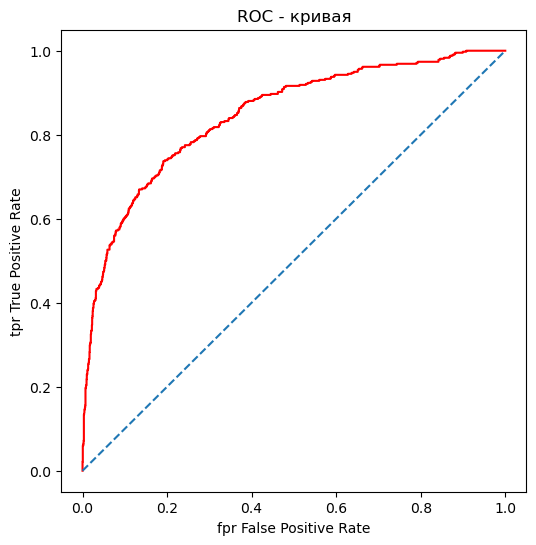

In [45]:
# Построим ROC - кривую
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr,  color='red')
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC - кривая')
plt.xlabel('fpr False Positive Rate')
plt.ylabel('tpr True Positive Rate')
plt.show()

In [46]:
# Дополнительно измерим AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('auc_roc', auc_roc)

auc_roc 0.8464521621834151


**Вывод**: 
- проверка на адекватность показала, что доля пралильных ответов accuracy в полученной модели выше чем аналогичный показатель случайной модели. Делаем вывод, что полученная нами модель является полезной.
- ROC-кривая, расположенная выше и левее, что свидетельствует о большей предсказательной способности модели.
- auc больше 0,8, т.е. можно говорить о том, что модель обладает высокой прогностической силой.

### Общий вывод
В этом проекте мы иссследовали датафрейм Churn.csv.
Изучили общую информацию датафрейма, выявили пропуски в столбце Tenure. 
Данные пропуски мы решили заполнить случайными числами от 0 до 10 т.к. чтобы сохранить равномерность распределения.
Изучили корреляцию столбцов, проверили на явные дубликаты и удалили лишние столбцы `Surname`, `RowNumber`, `CustomerId`.

С помощью кодирования OneHotEncoder из библиотеки sklearn и StandardScaler преобразовали категориальные и численные признаки, разделили датафрейм на тренировочную, валидационную и тестовую в соотношении 6:2:2
Выявили дисбаланс классов. 

Провели обучение моделей без учета дисбаланса. Получили лучшие показатели у модели дерева решений: F1 = 0.53.
Для этой модели построили матрицу ошибок и нашли значение recall.

Для борьбы с дисбалансом выбрали три способа:class_weight, увеличение выборки, уменьшение выборки.
В результате получили лучший результат метрики F1 у модели случайного леса на увеличенной выборке - 0.63. С оптимальными гиперпараметры модели: максимальная глубина - 8; число деревьев - 27.

При тестировании модели получили F1 примерно 0.608.
проверка на адекватность показала, что доля пралильных ответов accuracy в полученной модели выше чем аналогичный показатель случайной модели. т.е. полученная нами модель является полезной.
ROC-кривая, расположенная выше и левее, что свидетельствует о большей предсказательной способности модели.
auc больше 0,8, т.е. можно говорить о том, что модель обладает высокой прогностической силой.

